In [1]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
wave_len_long = 1600
wave_len_mini = 160
window_size = 4
data_dim = 2
latent_dim_long = 256 #1024
latent_dim_mini = 64

In [3]:
def res_block(inputs, filters, kernel_size, strides=(1, 1), activation=tf.nn.relu, kernel_initializer=None):
    x = inputs

    x = tf.layers.conv2d(x, filters, kernel_size=kernel_size, strides=strides, padding="same", kernel_initializer=kernel_initializer)
    x = tf.layers.batch_normalization(x, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=kernel_initializer)
    x = activation(x)

    x = tf.layers.conv2d(x, filters, kernel_size=kernel_size, strides=strides, padding="same", kernel_initializer=kernel_initializer)
    x = tf.layers.batch_normalization(x, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=kernel_initializer)
    x = activation(x + inputs)

    return x

def leaky_relu(x, alpha):
    return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

def encoder(inputs): # 話者以外の情報を保持する潜在空間へ写像する
    h = 64
    initializer = tf.random_normal_initializer(0, 0.02)

    x = inputs

    # -------
    x = tf.layers.conv2d(x, h, kernel_size=(window_size, 1), strides=(1, 1), padding="same", kernel_initializer=initializer) # 2->h
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, (4, 1), (4, 1), padding='same') # 1600*1*h -> 400*1*h
    
    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, (4, 1), (4, 1), padding='same') # 400*1*h -> 100*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, (4, 1), (4, 1), padding='same') # 100*1*h -> 25*1*h
    
    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)

    # -------
    x = tf.reshape(x, shape=(-1, h * 25)) # 1600
    x = tf.layers.dense(x, latent_dim_long, kernel_initializer=initializer) # 256
    
    x = tf.nn.tanh(x)

    return x

def encoder_split(inputs): # 
    initializer = tf.random_normal_initializer(0, 0.02)
    x = inputs
    x0 = tf.nn.tanh(tf.layers.dense(x, latent_dim_mini, kernel_initializer=initializer)) # 64
    x1 = tf.nn.tanh(tf.layers.dense(x, latent_dim_mini, kernel_initializer=initializer)) # 64
    x2 = tf.nn.tanh(tf.layers.dense(x, latent_dim_mini, kernel_initializer=initializer)) # 64
    x3 = tf.nn.tanh(tf.layers.dense(x, latent_dim_mini, kernel_initializer=initializer)) # 64
    x4 = tf.nn.tanh(tf.layers.dense(x, latent_dim_mini, kernel_initializer=initializer)) # 64
    x5 = tf.nn.tanh(tf.layers.dense(x, latent_dim_mini, kernel_initializer=initializer)) # 64
    x6 = tf.nn.tanh(tf.layers.dense(x, latent_dim_mini, kernel_initializer=initializer)) # 64
    x7 = tf.nn.tanh(tf.layers.dense(x, latent_dim_mini, kernel_initializer=initializer)) # 64
    x8 = tf.nn.tanh(tf.layers.dense(x, latent_dim_mini, kernel_initializer=initializer)) # 64
    x9 = tf.nn.tanh(tf.layers.dense(x, latent_dim_mini, kernel_initializer=initializer)) # 64
    
    return x0,x1,x2,x3,x4,x5,x6,x7,x8,x9

def decoder_mini(inputs): # decoderから呼ばれる時以外では使わない
    h = 64
    initializer = tf.random_normal_initializer(0, 0.02)
    
    x = inputs # 64
    
    # -------
    x = tf.layers.dense(x, h * 20, kernel_initializer=initializer) # 64*20 = 1280
    x = tf.reshape(x, shape=(-1, 20, 1, h)) # 20*1*h

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 2, x.shape[2])) # 40

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 2, x.shape[2])) # 80

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 2, x.shape[2])) # 160

    # -------
    x = res_block(x, h, kernel_size=(window_size, 1), kernel_initializer=initializer) # 160
    x = tf.layers.conv2d(x, data_dim, kernel_size=1, padding="same", kernel_initializer=initializer)

    return x

def decoder(inputs): # 同じベクトルを10個与えたときに同じものが出力されているかで変数の共有を確認する
#     x0,x1,x2,x3,x4,x5,x6,x7,x8,x9 = inputs
#     with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x0 = _decoder_mini(x0)
#     with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x1 = _decoder_mini(x1)
#     with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x2 = _decoder_mini(x2)
#     with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x3 = _decoder_mini(x3)
#     with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x4 = _decoder_mini(x4)
#     with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x5 = _decoder_mini(x5)
#     with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x6 = _decoder_mini(x6)
#     with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x7 = _decoder_mini(x7)
#     with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x8 = _decoder_mini(x8)
#     with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x9 = _decoder_mini(x9)

#     return tf.concat([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9], 0)
    return tf.concat(inputs, 1)

In [4]:
inputs = tf.placeholder(tf.float32, (None, wave_len_long, data_dim))

encoded = encoder_split(encoder(tf.reshape(inputs, (-1, wave_len_long, 1, data_dim))))

with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x0 = decoder_mini(encoded[0])
with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x1 = decoder_mini(encoded[1])
with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x2 = decoder_mini(encoded[2])
with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x3 = decoder_mini(encoded[3])
with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x4 = decoder_mini(encoded[4])
with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x5 = decoder_mini(encoded[5])
with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x6 = decoder_mini(encoded[6])
with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x7 = decoder_mini(encoded[7])
with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x8 = decoder_mini(encoded[8])
with tf.variable_scope('decoder_mini', reuse=tf.AUTO_REUSE): x9 = decoder_mini(encoded[9])


# x0 = decoder_mini(encoded[0])
# x1 = decoder_mini(encoded[1])
# x2 = decoder_mini(encoded[2])
# x3 = decoder_mini(encoded[3])
# x4 = decoder_mini(encoded[4])
# x5 = decoder_mini(encoded[5])
# x6 = decoder_mini(encoded[6])
# x7 = decoder_mini(encoded[7])
# x8 = decoder_mini(encoded[8])
# x9 = decoder_mini(encoded[9])

decoded = tf.reshape(decoder([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9]), (-1, wave_len_long, data_dim))
# decoded = decoder([x0,x1,x2,x3,x4,x5,x6,x7,x8,x9])

In [5]:
decoded.shape

TensorShape([Dimension(None), Dimension(1600), Dimension(2)])

In [6]:
loss = tf.reduce_mean(tf.pow(inputs - decoded, 2))

In [7]:
lr = 8e-4
beta1= 0.5
beta2 = 0.9
optimize = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

(10370160, 2) 48000


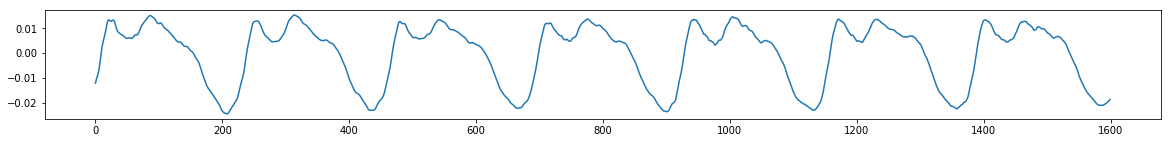

['../VoiceData/tamaneuta/trim_data/utama1.wav',
 '../VoiceData/tamaneuta/trim_data/utama2.wav',
 '../VoiceData/tamaneuta/trim_data/utama3.wav',
 '../VoiceData/tamaneuta/trim_data/utama4.wav',
 '../VoiceData/tamaneuta/trim_data/utama5.wav',
 '../VoiceData/tamaneuta/trim_data/utama6.wav',
 '../VoiceData/tamaneuta/trim_data/utama7.wav',
 '../VoiceData/tamaneuta/trim_data/utama8.wav',
 '../VoiceData/tamaneuta/trim_data/utama9.wav']

In [8]:
import soundfile as sf
import os

path = "../VoiceData/tamaneuta/trim_data/"
files = sorted(os.listdir(path))
files = [path + file for file in files]

data1, rate = sf.read(files[0]) # rate == 48000 # samplerate:1秒あたりのフレーム数
print(data1.shape, rate)
_s = 1000000
_data1 = data1[_s:_s+wave_len_long,0]
plt.figure(figsize=(20,2));plt.plot(_data1);plt.show()

files

In [9]:
import random

class Generator(object):
    def __init__(self):
        pass
        
    def generate(self, index, shuffle=True, DEMO=False, NO_SILENT=True):
        data = []
        amp = []
        wave, _ = sf.read(files[index])
        
        for i in range(0, int(len(wave)/wave_len_long)):
            _data = wave[i*wave_len_long:(i+1)*wave_len_long]
            _amp = np.max(np.abs(_data))
            if NO_SILENT and _amp < 0.005: # 無音を捨てる
                continue
            data.append(_data/_amp)
            amp.append(_amp)

        if shuffle:
            temp = list(zip(data, amp))
            np.random.shuffle(temp)
            data, amp = zip(*temp)
        
        data = np.array(data)
        amp = np.array(amp)
        
        if DEMO:
            print("wave")
            for i in range(3):
                print(amp[i])
                plt.figure(figsize=(20,1))
                plt.plot(data[i])
                plt.show()
                
            print("amp")
            # file番号によって変わる
            plt.figure(figsize=(3,2))
            plt.hist(amp, bins=500)
            plt.axvline(0.005, color="r")
            plt.show()
            
        if DEMO:
            print("data.shape ==", data.shape)
            print("amp.shape ==", amp.shape)

        return data, amp
    
gen = Generator()

In [10]:
class Generator_for_realtime(object):
    def __init__(self):
        pass
        
    def generate(self, index, shuffle=True, DEMO=False, NO_SILENT=True):
        data = []
        amp = []
        wave, _ = sf.read(files[index])
        t = 0
        while t < len(wave):
            _data = wave[t:t+wave_len_long]
            
            t += wave_len_long - 20*2 - 40 # 20==切り捨てる量, 40==かぶせる量
            
            if not len(_data) == wave_len_long:
                continue
            _amp = np.max(np.abs(_data))
            
            data.append(_data/_amp)
            amp.append(_amp)
            

        data = np.array(data)
        amp = np.array(amp)
        
        return data, amp

In [11]:
gen = Generator()
# gen = Generator_for_realtime()
data, amp = gen.generate(0)
data.shape

(5672, 1600, 2)

wave
0.047271728515625


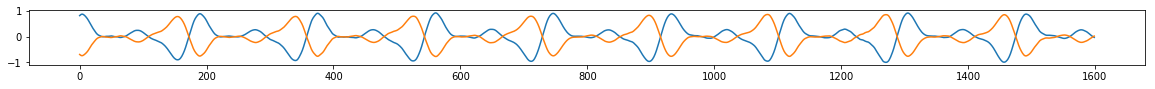

0.042327880859375


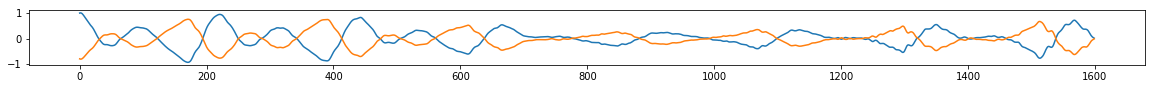

0.06884765625


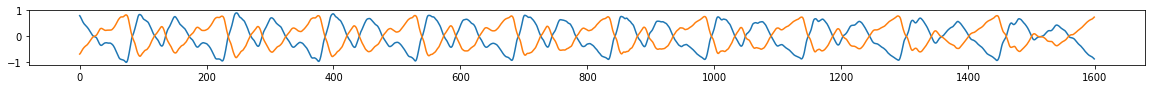

amp


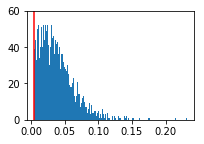

data.shape == (5672, 1600, 2)
amp.shape == (5672,)


In [12]:
data, amp = gen.generate(0, DEMO=True)

In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()

with tf.name_scope('summary'):
    tf.summary.scalar('loss', loss)
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('./logs', sess.graph)

sess.run(init)

saver = tf.train.Saver()
# saver.restore(sess, './model/model-c-89')

batch_size = 128
epoch = 0

In [14]:
max_epoch = 10

In [15]:
for _ in range(epoch, max_epoch):    
    for file in range(len(files)):
#     for file in range(1):
        data, _ = gen.generate(file)
        loss_hist = []
        for index in tqdm(range(0, int(len(data)), batch_size)):
            batch = data[index:index+batch_size]
            _, _loss = sess.run([optimize, loss], {inputs: batch})
            loss_hist.append(_loss)
        print("epoch:", epoch+1, "file:", file+1, ", loss_sum:", np.mean(loss_hist))
    epoch += 1
    saver.save(sess, './model/model', global_step=epoch+1)

100%|██████████| 45/45 [00:09<00:00,  4.79it/s]


epoch: 1 file: 1 , loss_sum: 0.0785044


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 1 file: 2 , loss_sum: 0.024395468


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 1 file: 3 , loss_sum: 0.019345898


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 1 file: 4 , loss_sum: 0.017024605


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 1 file: 5 , loss_sum: 0.014475606


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 1 file: 6 , loss_sum: 0.017484643


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 1 file: 7 , loss_sum: 0.014234719


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 1 file: 8 , loss_sum: 0.012107598


100%|██████████| 45/45 [00:07<00:00,  6.25it/s]


epoch: 1 file: 9 , loss_sum: 0.011771666


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 2 file: 1 , loss_sum: 0.008970859


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 2 file: 2 , loss_sum: 0.009008329


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 2 file: 3 , loss_sum: 0.0097316075


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 2 file: 4 , loss_sum: 0.00992876


100%|██████████| 48/48 [00:07<00:00,  6.52it/s]


epoch: 2 file: 5 , loss_sum: 0.009783508


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 2 file: 6 , loss_sum: 0.01362726


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 2 file: 7 , loss_sum: 0.011937915


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 2 file: 8 , loss_sum: 0.010531886


100%|██████████| 45/45 [00:06<00:00,  6.54it/s]


epoch: 2 file: 9 , loss_sum: 0.009928567


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 3 file: 1 , loss_sum: 0.0072914157


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 3 file: 2 , loss_sum: 0.007900762


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 3 file: 3 , loss_sum: 0.008751173


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 3 file: 4 , loss_sum: 0.009115006


100%|██████████| 48/48 [00:07<00:00,  6.76it/s]


epoch: 3 file: 5 , loss_sum: 0.009025204


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 3 file: 6 , loss_sum: 0.012707042


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 3 file: 7 , loss_sum: 0.010981436


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 3 file: 8 , loss_sum: 0.009553644


100%|██████████| 45/45 [00:06<00:00,  6.75it/s]


epoch: 3 file: 9 , loss_sum: 0.008813525


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 4 file: 1 , loss_sum: 0.006570467


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 4 file: 2 , loss_sum: 0.007259875


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 4 file: 3 , loss_sum: 0.00809055


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 4 file: 4 , loss_sum: 0.008409018


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 4 file: 5 , loss_sum: 0.008077306


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 4 file: 6 , loss_sum: 0.011982334


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 4 file: 7 , loss_sum: 0.010304325


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 4 file: 8 , loss_sum: 0.009080955


100%|██████████| 45/45 [00:06<00:00,  6.61it/s]


epoch: 4 file: 9 , loss_sum: 0.008274738


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 5 file: 1 , loss_sum: 0.006245444


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 5 file: 2 , loss_sum: 0.0068181194


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 5 file: 3 , loss_sum: 0.0076088347


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 5 file: 4 , loss_sum: 0.008504362


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 5 file: 5 , loss_sum: 0.008523904


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 5 file: 6 , loss_sum: 0.011412442


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 5 file: 7 , loss_sum: 0.010010482


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 5 file: 8 , loss_sum: 0.008526282


100%|██████████| 45/45 [00:06<00:00,  6.48it/s]


epoch: 5 file: 9 , loss_sum: 0.0076981066


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 6 file: 1 , loss_sum: 0.005858246


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 6 file: 2 , loss_sum: 0.006470444


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 6 file: 3 , loss_sum: 0.00730623


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 6 file: 4 , loss_sum: 0.0073239156


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 6 file: 5 , loss_sum: 0.008143618


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 6 file: 6 , loss_sum: 0.010321571


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 6 file: 7 , loss_sum: 0.009159879


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 6 file: 8 , loss_sum: 0.008423294


100%|██████████| 45/45 [00:06<00:00,  6.50it/s]


epoch: 6 file: 9 , loss_sum: 0.0074555324


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 7 file: 1 , loss_sum: 0.0053529995


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 7 file: 2 , loss_sum: 0.005975914


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 7 file: 3 , loss_sum: 0.006732019


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 7 file: 4 , loss_sum: 0.0068803066


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 7 file: 5 , loss_sum: 0.006709093


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 7 file: 6 , loss_sum: 0.009446782


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 7 file: 7 , loss_sum: 0.008456667


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 7 file: 8 , loss_sum: 0.0074999174


100%|██████████| 45/45 [00:06<00:00,  6.52it/s]


epoch: 7 file: 9 , loss_sum: 0.0066703106


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 8 file: 1 , loss_sum: 0.00487042


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 8 file: 2 , loss_sum: 0.0055543804


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 8 file: 3 , loss_sum: 0.006317611


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 8 file: 4 , loss_sum: 0.006427435


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 8 file: 5 , loss_sum: 0.006617682


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 8 file: 6 , loss_sum: 0.009053004


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 8 file: 7 , loss_sum: 0.008046632


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 8 file: 8 , loss_sum: 0.0072248816


100%|██████████| 45/45 [00:06<00:00,  6.50it/s]


epoch: 8 file: 9 , loss_sum: 0.0065700775


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 9 file: 1 , loss_sum: 0.004635738


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 9 file: 2 , loss_sum: 0.0053190277


100%|██████████| 47/47 [00:07<00:00,  6.40it/s]


epoch: 9 file: 3 , loss_sum: 0.006046215


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 9 file: 4 , loss_sum: 0.006152855


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 9 file: 5 , loss_sum: 0.006081054


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 9 file: 6 , loss_sum: 0.008699891


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 9 file: 7 , loss_sum: 0.0077714673


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 9 file: 8 , loss_sum: 0.007000523


100%|██████████| 45/45 [00:06<00:00,  6.55it/s]


epoch: 9 file: 9 , loss_sum: 0.0062236846


  0%|          | 0/49 [00:00<?, ?it/s]

epoch: 10 file: 1 , loss_sum: 0.004370476


  0%|          | 0/47 [00:00<?, ?it/s]

epoch: 10 file: 2 , loss_sum: 0.0050746067


  0%|          | 0/46 [00:00<?, ?it/s]

epoch: 10 file: 3 , loss_sum: 0.0057936464


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 10 file: 4 , loss_sum: 0.0058784215


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 10 file: 5 , loss_sum: 0.005818629


  0%|          | 0/48 [00:00<?, ?it/s]

epoch: 10 file: 6 , loss_sum: 0.008566811


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 10 file: 7 , loss_sum: 0.007439842


  0%|          | 0/45 [00:00<?, ?it/s]

epoch: 10 file: 8 , loss_sum: 0.006738407


100%|██████████| 45/45 [00:06<00:00,  6.67it/s]


epoch: 10 file: 9 , loss_sum: 0.0060729976


In [16]:
saver.save(sess, './model/model-spcon', global_step=epoch)

'./model/model-spcon-10'

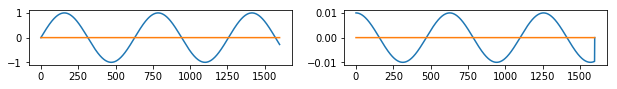

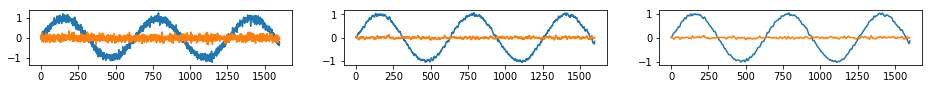

In [24]:
def df(f):
    df = np.zeros((len(f),2))
    df[:-1] = f[1:] - f[:-1]
    return df

def denoise(f):
    v = np.ones(8)/8
    f = np.array([np.convolve(fi,v, mode='same') for fi in f.T]).T
    return f

_x = np.zeros((1600,2))
_x[:,0] = np.sin(np.arange(1600)/100.0) # y = sin(x/100) dy/dx = 1/100*cos(x/100)
plt.figure(figsize=(16,1))
plt.subplot(1,3,1); plt.plot(_x)
plt.subplot(1,3,2); plt.plot(df(_x)); plt.show()

_x = np.zeros((1600,2))
_x[:,0] = np.sin(np.arange(1600)/100.0)
_x += np.random.randn(1600,2)/10
plt.figure(figsize=(16,1))
plt.subplot(1,3,1); plt.plot(_x)
plt.subplot(1,3,2); plt.plot(denoise(_x))
plt.subplot(1,3,3); plt.plot(denoise(denoise(_x))); plt.show()

(1600, 2) amp: 0.001800537109375 

original -> df -> ddf


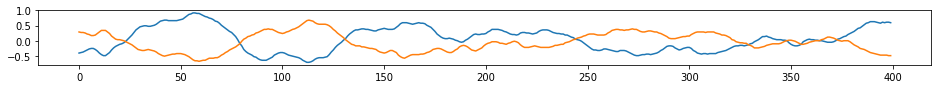

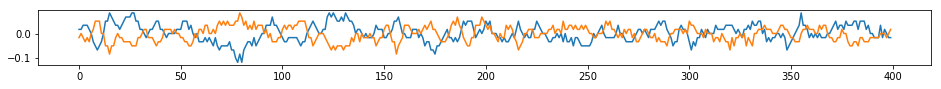

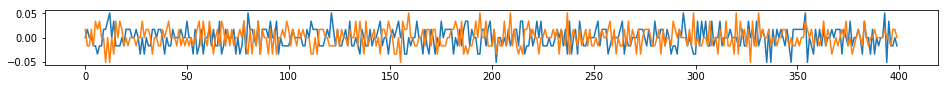

autoencoded -> df -> ddf


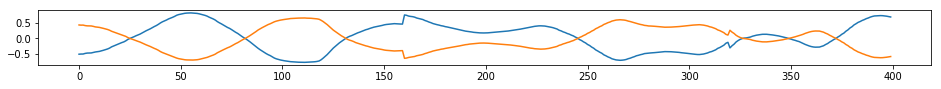

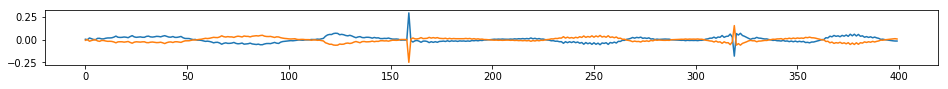

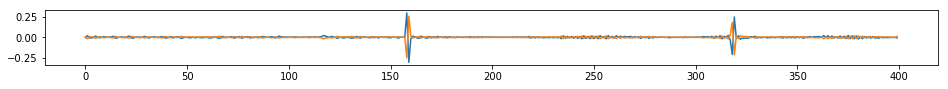

In [53]:
data, amp = gen.generate(0)
index = np.random.choice(len(data))
x = data[index]
a = amp[index]
print(x.shape, "amp:", a, "\n")
_x = x.reshape(wave_len_long, data_dim)
print("original -> df -> ddf")
plt.figure(figsize=(16,1)); plt.plot(_x[:400]); plt.show()
plt.figure(figsize=(16,1)); plt.plot(df(_x)[:400]); plt.show()
plt.figure(figsize=(16,1)); plt.plot(df(df(_x))[:400]); plt.show()

x = sess.run(decoded, {inputs: [_x]})
x = x[0].reshape(wave_len_long, data_dim)
print("autoencoded -> df -> ddf")
plt.figure(figsize=(16,1)); plt.plot(x[:400]); plt.show()
plt.figure(figsize=(16,1)); plt.plot(df(x)[:400]); plt.show()
plt.figure(figsize=(16,1)); plt.plot(df(df(x))[:400]); plt.show()

(1600, 2) amp: 0.055877685546875
inputs


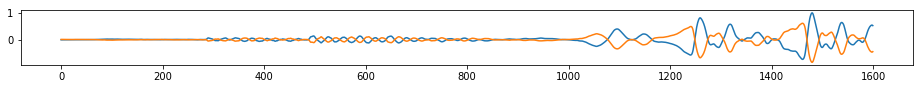

decoded


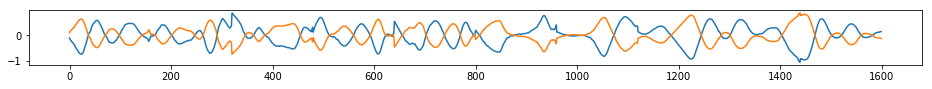

NameError: name 'inputs_fft_0' is not defined

In [19]:
data, amp = gen.generate(0)
index = np.random.choice(len(data))
x = data[index]
a = amp[index]
print(x.shape, "amp:", a)

_x = x.reshape(wave_len_long, data_dim)
print("inputs")
plt.figure(figsize=(16,1)); plt.plot(_x); plt.show()

x = sess.run(decoded, {inputs: [_x]})
print("decoded")
plt.figure(figsize=(16,1)); plt.plot(x[0]); plt.show()

x = sess.run(inputs_fft_0, {inputs: [_x]})
print("inputs_fft")
A1 = np.real(x.T)
A2 = np.imag(x.T)
plt.figure(figsize=(16,1)); plt.ylim([-250,250]); plt.plot(A1); plt.plot(A2); plt.show()
plt.figure(figsize=(16,1)); plt.plot(np.log(np.abs(A1)+1)); plt.plot(np.log(np.abs(A2)+1)); plt.show()
plt.figure(figsize=(16,1)); plt.plot(np.log(np.log(np.abs(A1)+1)+1)); plt.plot(np.log(np.log(np.abs(A2)+1)+1)); plt.show()

x = sess.run(decoded_fft_0, {inputs: [_x]})
print("decoded_fft")
B1 = np.real(x.T)
B2 = np.imag(x.T)
plt.figure(figsize=(16,1)); plt.ylim([-250,250]); plt.plot(B1); plt.plot(B2); plt.show()
plt.figure(figsize=(16,1)); plt.plot(np.log(np.abs(B1)+1)); plt.plot(np.log(np.abs(B2)+1)); plt.show()
plt.figure(figsize=(16,1)); plt.plot(np.log(np.log(np.abs(B1)+1)+1)); plt.plot(np.log(np.log(np.abs(B2)+1)+1)); plt.show()

In [ ]:
print("fft_diff")
plt.figure(figsize=(20,1)); plt.plot(np.abs(A1-B1)); plt.plot(np.abs(A2-B2)); plt.show()
plt.figure(figsize=(20,1)); plt.plot(np.log(np.abs(A1-B1)+1)); plt.plot(np.log(np.abs(A2-B2)+1)); plt.show()
# plt.figure(figsize=(20,1)); plt.plot(np.log(np.log(np.abs(A1-B1)+1)+1)); plt.plot(np.log(np.log(np.abs(A2-B2)+1)+1)); plt.show()

### AutoEncode

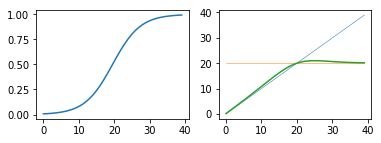

In [17]:
def sigmoid(size):
    x = np.linspace(0,1,size)
    x = (x - np.mean(x))*10
    y = 1 / (1 + np.e**-x)
    return y

def connect(a, b, DEMO=False):
    w = sigmoid(40)
    c = a*np.array([(1-w)]) + b*np.array([w])
    return c[0]

plt.figure(figsize=(6,2)); 
plt.subplot(1,2,1); plt.plot(sigmoid(40))
a = np.arange(0,40); b = np.ones(40)*20
plt.subplot(1,2,2); plt.plot(a, linewidth=0.5); plt.plot(b, linewidth=0.5); plt.plot(connect(a,b)); plt.show()

In [45]:
gen = Generator()

ae_data = []

for fi in range(1):
    batch_size = 128
    data, amp = gen.generate(fi, shuffle=False, NO_SILENT=False)

    for index in tqdm(range(0, len(data), batch_size)):
        batch_data = data[index:index+batch_size]
        batch_amp = amp[index:index+batch_size]
        _ae_data = sess.run(decoded, {inputs: batch_data})
        if not _ae_data.shape == (batch_size, 160,2):
            continue
            
        ae_data.extend(_ae_data*batch_amp.reshape(-1,1,1))
        
ae_data = np.array(ae_data)
print(ae_data.shape)
ae_data = ae_data.reshape(-1, data_dim)
sf.write("sample/wavelenmini_10epoch_no_connect.wav", ae_data, rate)

100%|██████████| 507/507 [00:03<00:00, 144.56it/s]


(64768, 160, 2)


In [18]:
gen = Generator_for_realtime()

ae_data = []

for fi in range(1):
    batch_size = 128
    data, amp = gen.generate(fi)

    for index in tqdm(range(0, len(data), batch_size)):
        batch_data = data[index:index+batch_size]
        batch_amp = amp[index:index+batch_size]
        _ae_data = sess.run(decoded, {inputs: batch_data})
        if not _ae_data.shape == (batch_size, 1600,2):
            continue
        # denoiseしない方が良い
        ae_data.extend(_ae_data*batch_amp.reshape(-1,1,1))
#         _ae_data = np.array([denoise(_data) for _data in _ae_data])
#         _ae_data = np.array([denoise(_data) for _data in _ae_data]) # denoise2回する
#         ae_data.extend(_ae_data*batch_amp.reshape(-1,1,1))

100%|██████████| 54/54 [00:03<00:00, 17.43it/s]


In [19]:
ae_data = np.array(ae_data)
print(ae_data.shape)

(6784, 1600, 2)


In [20]:
concat_data = [ae_data[0, 60:-20]]

for _ae_data in tqdm(ae_data[1:]):
    _ae_data = _ae_data[20:-20] # 新しいデータ。最初と最後は切り捨てておく。(1560, 2)
    a = concat_data[-1][-40:] # 古いデータの尻。(40, 2)
    b = _ae_data[:40] # 新しいデータの頭。(40, 2)
    concat_data[-1][-40:,0] = connect(a[:,0],b[:,0]) # 古いデータを上書き
    concat_data[-1][-40:,1] = connect(a[:,1],b[:,1]) # 古いデータを上書き
#     concat_data = np.vstack([concat_data, _ae_data[40:]])
    
    concat_data.append(_ae_data[40:])

100%|██████████| 6783/6783 [00:00<00:00, 11233.35it/s]


In [21]:
concat_data = np.array(concat_data).reshape(-1, data_dim)
# sf.write("sample/wavelenmini_10epoch_allfiles.wav", concat_data[:int(len(concat_data)/3.58/3)], rate)
sf.write("sample/wavelenmini_spcon_10epoch.wav", concat_data, rate)